In [175]:
import warnings
warnings.filterwarnings('ignore')

## Preprocessing

### *Load the data*

In [142]:
import pandas as pd

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print(df_train.shape)
print(df_test.shape)

(20812, 11)
(5203, 10)


In [143]:
df_train.columns

Index(['Fiscal Year Released', 'Main Supervising District', 'Release Type',
       'Race - Ethnicity', 'Age At Release ', 'Sex', 'Return to Prison',
       'Days to Return', 'Recidivism Type', 'Offense', 'New Offense'],
      dtype='object')

In [144]:
df_test.columns

Index(['Fiscal Year Released', 'Main Supervising District', 'Release Type',
       'Race - Ethnicity', 'Age At Release ', 'Sex', 'Return to Prison',
       'Days to Return', 'Recidivism Type', 'Offense'],
      dtype='object')

In [145]:
df_train.head()

,Fiscal Year Released,Main Supervising District,Release Type,Race - Ethnicity,Age At Release,Sex,Return to Prison,Days to Return,Recidivism Type,Offense,New Offense
0,2013,5JD,Parole Granted,Black - Non-Hispanic,35-44,Male,No,NaN,No Recidivism,Drug-Trafficking,No recidivism
1,2013,7JD,Paroled to Detainer - Out of State,White - Non-Hispanic,35-44,Male,Yes,724.0,Tech,Other-Other Criminal,No recidivism
2,2013,NaN,Paroled w/Immediate Discharge,Black - Non-Hispanic,45-54,Male,No,NaN,No Recidivism,Drug-Trafficking,No recidivism
3,2013,8JD,Parole Granted,Black - Non-Hispanic,45-54,Male,Yes,637.0,New,Property-Forgery/Fraud,Property-Theft
4,2014,NaN,NaN,Black - Non-Hispanic,Under 25,Male,No,NaN,No Recidivism,Violent-Sex,No recidivism


In [146]:
df_train.dtypes

Fiscal Year Released           int64
Main Supervising District     object
Release Type                  object
Race - Ethnicity              object
Age At Release                object
Sex                           object
Return to Prison              object
Days to Return               float64
Recidivism Type               object
Offense                       object
New Offense                   object
dtype: object

In [147]:
df_train['Fiscal Year Released'] = df_train['Fiscal Year Released'].astype('str')
df_test['Fiscal Year Released'] = df_test['Fiscal Year Released'].astype('str')

### *Create monthly categories*

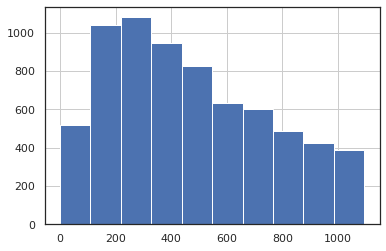

In [148]:
# convert days to return to class
df_train['Days to Return'].hist()

In [149]:
df_train['Days to Return'].describe()

count    6945.000000
mean      471.505544
std       282.387177
min         0.000000
25%       238.000000
50%       423.000000
75%       684.000000
max      1095.000000
Name: Days to Return, dtype: float64

In [150]:
def create_bins_days(df):
  # create 6 categories for days to return
  days = df['Days to Return']
  days = days.fillna(0)
  values = []
  for d in days:
    if d == 0.0:
      values.append("no recidivism")
    elif d > 0.0 and d < 180:
      values.append("less than 6 months") 
    elif d >= 180 and d < 360:
      values.append("6-12 months")
    elif d >= 360 and d < 540:
      values.append("12-18 months")
    elif d >= 540 and d < 720:
      values.append("18-24 months")
    else:
      values.append("more than 24 months")

  # create new column 
  df['Months to return'] = values 
  # drop old column
  df = df.drop('Days to Return', axis=1)
  
  return df


In [151]:
df_train = create_bins_days(df_train)
df_test = create_bins_days(df_test)

In [152]:
df_train.head()

,Fiscal Year Released,Main Supervising District,Release Type,Race - Ethnicity,Age At Release,Sex,Return to Prison,Recidivism Type,Offense,New Offense,Months to return
0,2013,5JD,Parole Granted,Black - Non-Hispanic,35-44,Male,No,No Recidivism,Drug-Trafficking,No recidivism,no recidivism
1,2013,7JD,Paroled to Detainer - Out of State,White - Non-Hispanic,35-44,Male,Yes,Tech,Other-Other Criminal,No recidivism,more than 24 months
2,2013,NaN,Paroled w/Immediate Discharge,Black - Non-Hispanic,45-54,Male,No,No Recidivism,Drug-Trafficking,No recidivism,no recidivism
3,2013,8JD,Parole Granted,Black - Non-Hispanic,45-54,Male,Yes,New,Property-Forgery/Fraud,Property-Theft,18-24 months
4,2014,NaN,NaN,Black - Non-Hispanic,Under 25,Male,No,No Recidivism,Violent-Sex,No recidivism,no recidivism


In [153]:
df_train.dtypes

Fiscal Year Released         object
Main Supervising District    object
Release Type                 object
Race - Ethnicity             object
Age At Release               object
Sex                          object
Return to Prison             object
Recidivism Type              object
Offense                      object
New Offense                  object
Months to return             object
dtype: object

### *Correlation: Cramer V*

We are dealing with categorical features, thus, instead of computing the correlation we can compute a measure of association with [Cramer V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V) _Based on this [article](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)._


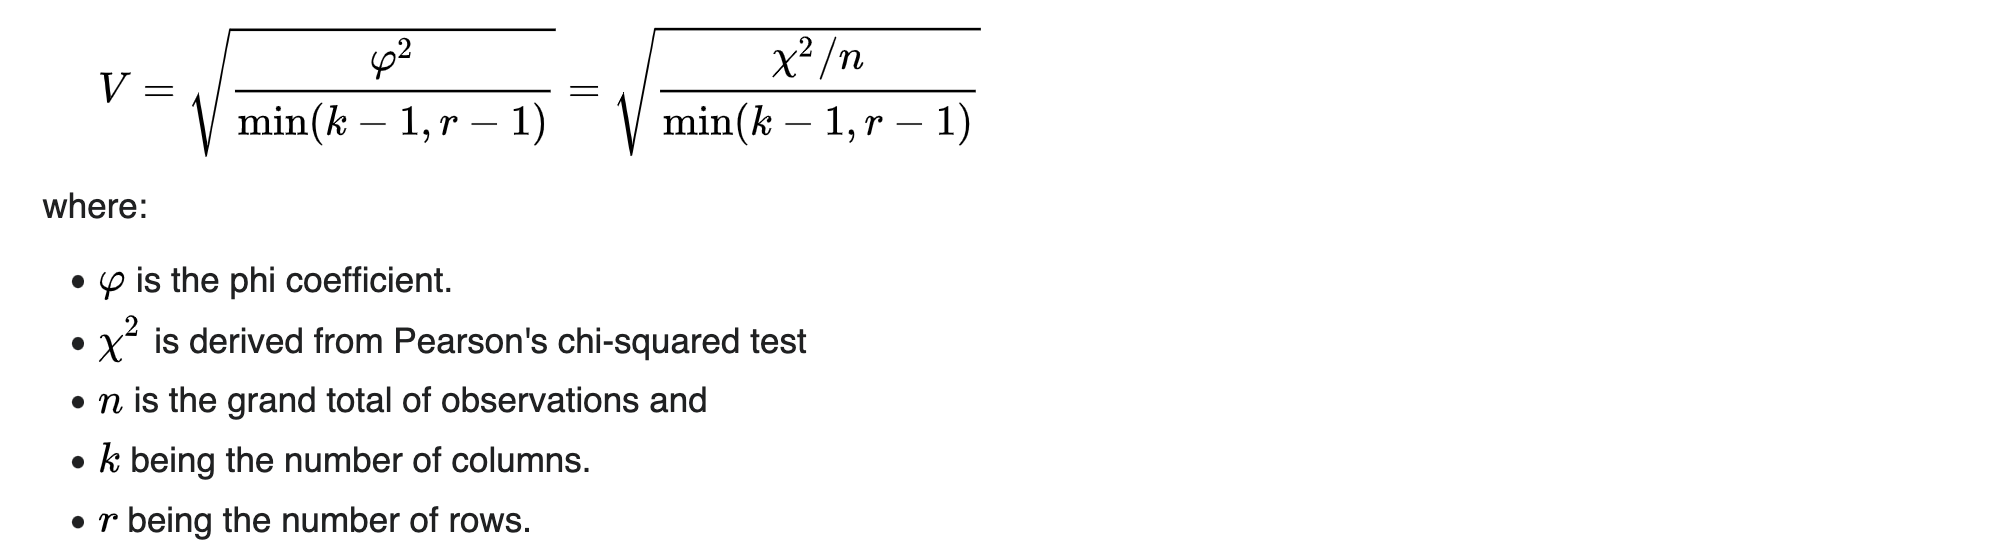

In [154]:
import scipy.stats as ss
import seaborn as sns
import numpy as np
from string import ascii_letters
import matplotlib.pyplot as plt

def cramers_v(x, y):
  '''Function to calculate Cramers V'''
  confusion_matrix = pd.crosstab(x,y)
  chi2 = ss.chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  phi2 = chi2/n
  r,k = confusion_matrix.shape
  phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
  rcorr = r-((r-1)**2)/(n-1)
  kcorr = k-((k-1)**2)/(n-1)
  return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def plot_corr(df, plot=True):
  '''Function to plot associations between categorical features,
  based on Cramer V.'''
  correlations = {}
  names = df.columns
  # create a dictionary with correlation values:
  # { age: {age: 1.0, race: 0.54, sex: 0.02, ...}}
  for column in df.columns:
    correlations.setdefault(column, {})
    for col in df.columns:
      correlations[column].setdefault(col, 0)
      correlations[column][col] += cramers_v(df[column], df[col])

  # create correlation dataframe
  corr = pd.DataFrame.from_dict(correlations)
  
  # plot = True
  if plot:
    sns.set(style="white")
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
  
  # plot = False
  else:
    return corr

# With Cramer V we can calculate the association between 2 categorcial features
cramers_v(df_train["Race - Ethnicity"], df_train["Return to Prison"])

0.07887796145171595

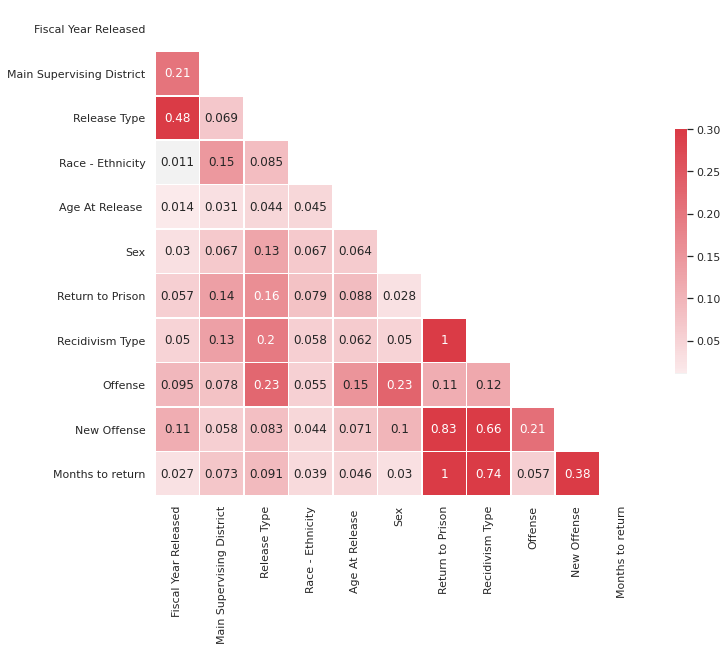

In [155]:
# plot associations
plot_corr(df_train)

## Prepare the data for Machine Learning Algorithms

### *Define the target*

In [156]:
target = 'New Offense'

### *Divide train and validation datasets*

In [157]:
from sklearn.model_selection import train_test_split

# Divide: 80% as training set and 20% as validation
df_train, df_valid = train_test_split(df_train, 
                                      train_size=.8, 
                                      random_state=42,
                                      stratify=df_train[target]) # stratify by target

# Reset the index in training and validation sets
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(16649, 11)
(4163, 11)
(5203, 10)


### *Handle identifiers*

In [158]:
# define function
def id_checker(df):
    df_id = df[[var for var in df.columns 
                if df[var].nunique(dropna=True) == df[var].notnull().sum()]] 
    
    if df_id.shape[1]==0:
      return "The data has no identifiers."
    else:     
      return df_id

# Call fuction 
id_checker(df_train)

'The data has no identifiers.'

### *Missing data*

In [159]:
def nan_checker(df):
    # Get the variables with NaN, their proportion of NaN and dtype
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    
    # Sort df_nan in accending order of the proportion of NaN
    df_nan = df_nan.sort_values(by='proportion', ascending=False)
    
    return df_nan

In [160]:
# Call nan_checker on df
df_nan = nan_checker(df_train)

# Print df_nan
df_nan.reset_index(drop=True)

,var,proportion,dtype
0,Main Supervising District,0.365127,object
1,Release Type,0.068593,object
2,Race - Ethnicity,0.000841,object
3,Age At Release,0.000060,object
4,Sex,0.000060,object


In [161]:
# Combine train, validation and test sets
df = pd.concat([df_train, df_valid, df_test], sort=False)

# Call nan_checker on df
df_nan = nan_checker(df)

# Print df_nan
df_nan.reset_index(drop=True)

,var,proportion,dtype
0,Main Supervising District,0.368288,object
1,New Offense,0.200000,object
2,Release Type,0.067730,object
3,Race - Ethnicity,0.001153,object
4,Age At Release,0.000115,object
5,Sex,0.000115,object


All features with missing values are categorical. In the case of release type, race-ethnicity, age at release and sex, is is assumed that there was an error when filling the information. These features will be dropped. In the case of Main supervising district, it is assumed that a missing value means that there was no supervisation of the released person. For this reason, this feature will not be dropped. The percentage of missing values of new offense correspond to the size of the test set. 

In [162]:
columns_to_drop = ['Release Type','Race - Ethnicity','Age At Release ','Sex']
df_train = df_train.dropna(subset= columns_to_drop)
df_test = df_test.dropna(subset= columns_to_drop)
df_valid = df_valid.dropna(subset= columns_to_drop)

In [163]:
# Print the dimension of the training and testing data
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(15492, 11)
(3873, 11)
(4855, 10)


### *One hot encoding of categorical features*

In [164]:
def cat_var_checker(df):
    # Get the dataframe of categorical variables and their number of unique value
    df_cat = pd.DataFrame([[var, df[var].nunique(dropna=False)]
                           for var in df.columns if df[var].dtype == 'object'],
                          columns=['var', 'nunique'])
    
    # Sort df_cat in accending order of the number of unique value
    df_cat = df_cat.sort_values(by='nunique', ascending=False)
    
    return df_cat

In [165]:
# Combine train, validation and test sets
df = pd.concat([df_train, df_valid, df_test], sort=False)

# Call cat_var_checker on df
df_cat = cat_var_checker(df)

# Print the dataframe
df_cat.reset_index(drop=True)

,var,nunique
0,Offense,27
1,New Offense,25
2,Main Supervising District,11
3,Release Type,11
4,Race - Ethnicity,11
5,Fiscal Year Released,6
6,Months to return,6
7,Age At Release,5
8,Recidivism Type,3
9,Sex,2


In [166]:
# Encode the categorical features
df = pd.get_dummies(df, columns=np.setdiff1d(np.intersect1d(df.columns, df_cat['var']),[target]))

# Print the first rows
df.head()

,New Offense,Age At Release _25-34,Age At Release _35-44,Age At Release _45-54,Age At Release _55 and Older,Age At Release _Under 25,Fiscal Year Released_2010,Fiscal Year Released_2011,Fiscal Year Released_2012,Fiscal Year Released_2013,Fiscal Year Released_2014,Fiscal Year Released_2015,Main Supervising District_1JD,Main Supervising District_2JD,Main Supervising District_3JD,Main Supervising District_4JD,Main Supervising District_5JD,Main Supervising District_6JD,Main Supervising District_7JD,Main Supervising District_8JD,Main Supervising District_ISC,Main Supervising District_Interstate Compact,Months to return_12-18 months,Months to return_18-24 months,Months to return_6-12 months,Months to return_less than 6 months,Months to return_more than 24 months,Months to return_no recidivism,Offense_Drug-Drug Possession,Offense_Drug-Other Drug,Offense_Drug-Trafficking,Offense_Other-Animals,Offense_Other-Other Criminal,Offense_Other-Other Violent,Offense_Other-Special Sentence Revocation,Offense_Property-Arson,Offense_Property-Burglary,Offense_Property-Forgery/Fraud,Offense_Property-Stolen Property,Offense_Property-Theft,...,Offense_Public Order-Other Public Order,Offense_Public Order-Prostitution/Pimping,Offense_Public Order-Sex Offender Registry/Residency,Offense_Public Order-Traffic,Offense_Public Order-Weapons,Offense_Violent-Assault,Offense_Violent-Kidnap,Offense_Violent-Murder/Manslaughter,Offense_Violent-Other Violent,Offense_Violent-Robbery,Offense_Violent-Sex,Race - Ethnicity_American Indian or Alaska Native - Hispanic,Race - Ethnicity_American Indian or Alaska Native - Non-Hispanic,Race - Ethnicity_Asian or Pacific Islander - Hispanic,Race - Ethnicity_Asian or Pacific Islander - Non-Hispanic,Race - Ethnicity_Black -,Race - Ethnicity_Black - Hispanic,Race - Ethnicity_Black - Non-Hispanic,Race - Ethnicity_N/A -,Race - Ethnicity_White -,Race - Ethnicity_White - Hispanic,Race - Ethnicity_White - Non-Hispanic,Recidivism Type_New,Recidivism Type_No Recidivism,Recidivism Type_Tech,Release Type_Discharged - Expiration of Sentence,Release Type_Discharged – End of Sentence,Release Type_Parole,Release Type_Parole Granted,Release Type_Paroled to Detainer - INS,Release Type_Paroled to Detainer - Iowa,Release Type_Paroled to Detainer - Out of State,Release Type_Paroled to Detainer - U.S. Marshall,Release Type_Paroled w/Immediate Discharge,Release Type_Released to Special Sentence,Release Type_Special Sentence,Return to Prison_No,Return to Prison_Yes,Sex_Female,Sex_Male
0,No recidivism,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,Property-Burglary,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
2,Property-Burglary,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
3,No recidivism,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
4,No recidivism,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


In [167]:
# Separate the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separate the validation data
df_valid = df.iloc[df_train.shape[0]:
                   df_train.shape[0] + df_valid.shape[0],:].copy(deep=True)

# Separate the testing data
df_test = df.iloc[df_train.shape[0] + df_valid.shape[0]:,:].copy(deep=True)

# Print the dimension of the training and testing data
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(15492, 84)
(3873, 84)
(4855, 84)


### *One hot encoding of the categorical target*

In [168]:
from sklearn.preprocessing import LabelEncoder

# Combine train, validation and test sets
df = pd.concat([df_train, df_valid, df_test], sort=False)

# The LabelEncoder
le = LabelEncoder()

# Encode the categorical target in the combined data
df[target] = le.fit_transform(df[target].astype(str))

# Print the first 5 rows of df
df.head()

,New Offense,Age At Release _25-34,Age At Release _35-44,Age At Release _45-54,Age At Release _55 and Older,Age At Release _Under 25,Fiscal Year Released_2010,Fiscal Year Released_2011,Fiscal Year Released_2012,Fiscal Year Released_2013,Fiscal Year Released_2014,Fiscal Year Released_2015,Main Supervising District_1JD,Main Supervising District_2JD,Main Supervising District_3JD,Main Supervising District_4JD,Main Supervising District_5JD,Main Supervising District_6JD,Main Supervising District_7JD,Main Supervising District_8JD,Main Supervising District_ISC,Main Supervising District_Interstate Compact,Months to return_12-18 months,Months to return_18-24 months,Months to return_6-12 months,Months to return_less than 6 months,Months to return_more than 24 months,Months to return_no recidivism,Offense_Drug-Drug Possession,Offense_Drug-Other Drug,Offense_Drug-Trafficking,Offense_Other-Animals,Offense_Other-Other Criminal,Offense_Other-Other Violent,Offense_Other-Special Sentence Revocation,Offense_Property-Arson,Offense_Property-Burglary,Offense_Property-Forgery/Fraud,Offense_Property-Stolen Property,Offense_Property-Theft,...,Offense_Public Order-Other Public Order,Offense_Public Order-Prostitution/Pimping,Offense_Public Order-Sex Offender Registry/Residency,Offense_Public Order-Traffic,Offense_Public Order-Weapons,Offense_Violent-Assault,Offense_Violent-Kidnap,Offense_Violent-Murder/Manslaughter,Offense_Violent-Other Violent,Offense_Violent-Robbery,Offense_Violent-Sex,Race - Ethnicity_American Indian or Alaska Native - Hispanic,Race - Ethnicity_American Indian or Alaska Native - Non-Hispanic,Race - Ethnicity_Asian or Pacific Islander - Hispanic,Race - Ethnicity_Asian or Pacific Islander - Non-Hispanic,Race - Ethnicity_Black -,Race - Ethnicity_Black - Hispanic,Race - Ethnicity_Black - Non-Hispanic,Race - Ethnicity_N/A -,Race - Ethnicity_White -,Race - Ethnicity_White - Hispanic,Race - Ethnicity_White - Non-Hispanic,Recidivism Type_New,Recidivism Type_No Recidivism,Recidivism Type_Tech,Release Type_Discharged - Expiration of Sentence,Release Type_Discharged – End of Sentence,Release Type_Parole,Release Type_Parole Granted,Release Type_Paroled to Detainer - INS,Release Type_Paroled to Detainer - Iowa,Release Type_Paroled to Detainer - Out of State,Release Type_Paroled to Detainer - U.S. Marshall,Release Type_Paroled w/Immediate Discharge,Release Type_Released to Special Sentence,Release Type_Special Sentence,Return to Prison_No,Return to Prison_Yes,Sex_Female,Sex_Male
0,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,7,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
2,7,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
3,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
4,3,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


In [169]:
# Separate the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separate the validation data
df_valid = df.iloc[df_train.shape[0]:
                   df_train.shape[0] + df_valid.shape[0],:].copy(deep=True)

# Separate the testing data
df_test = df.iloc[df_train.shape[0] + df_valid.shape[0]:,:].copy(deep=True)

# Print the dimension of the training and testing data
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(15492, 84)
(3873, 84)
(4855, 84)


### *Scaling*

All features are categorical and have already been one-hot encoding. Therefore, no scaling is needed.

### *Feature matrix and vector*

In [170]:
# Get the name of the features
features = np.setdiff1d(df.columns, [target])

# Get the feature matrix
X_train = df_train[features].to_numpy()
X_valid = df_valid[features].to_numpy()
X_test = df_test[features].to_numpy()

# Get the target vector
y_train = df_train[target].astype(int).to_numpy()
y_valid = df_valid[target].astype(int).to_numpy()

In [171]:
X_train

array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 1, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 1, 1, 0]], dtype=uint8)

## Logistic Regression

In [174]:
from sklearn.linear_model import LogisticRegression

# The LogisticRegression
lr = LogisticRegression(class_weight='balanced', random_state=42)

# Train the logistic regression model on the training data
lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### *Accuracy, Precision and Recall*

In [183]:
# Let's evaluate the model

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Get the prediction on the validation data using lr
y_valid_pred = lr.predict(X_valid)

# Get the accuracy
accuracy = accuracy_score(y_valid, y_valid_pred)
print("Accuracy: ", accuracy)

# Get the precision, recall, f-score and support
precision, recall, fscore, support = precision_recall_fscore_support(y_valid, y_valid_pred, average='macro')
print("Precision: ", precision)
print("Recall: ", recall)

Accuracy:  0.8466305189775368
Precision:  0.3885089522975626
Recall:  0.4717022552176566


The accuracy of the model is 85%. However, precision and recall are lower: 39% and 47%, respectively. Precision means that only 39% of the "positive" identifications were correctlt classified; whereas recall means that, of all the "actual positive" identifications, 47% were identified correctly.

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)


### *ROC-AUC*

In [180]:
import os

# Create a new directory for all figures
directory = os.path.dirname('./figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [184]:
from sklearn.metrics import plot_roc_curve

def plot_ROC(y_train):
  '''Plot ROC curves for all classes'''
  for class_ in np.unique(y_train):
    # run and train the model
    lr_class = LogisticRegression()
    lr_class.fit(X_train, (y_train == class_).astype(int))

    # Plot the ROC curve
    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()
    ax.set_title('class ' + str(class_))
    plot_roc_curve(lr_class, X_valid, (y_valid == class_).astype(int), ax=ax, name='', linewidth=2, color='green')
    plt.tight_layout()
    plt.savefig('./figure/roc' + '_' + str(class_) + '.pdf')
    plt.show()

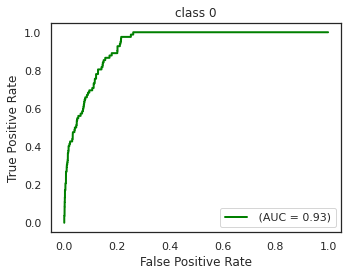

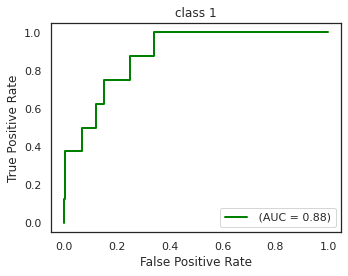

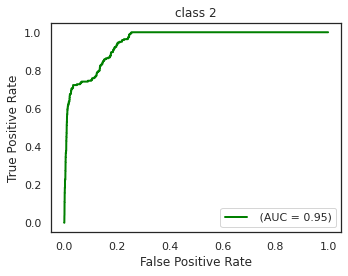

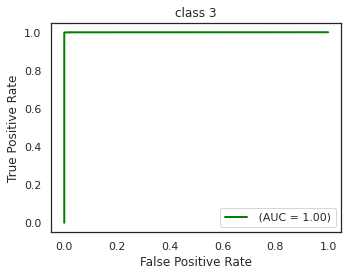

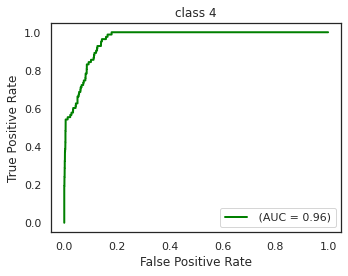

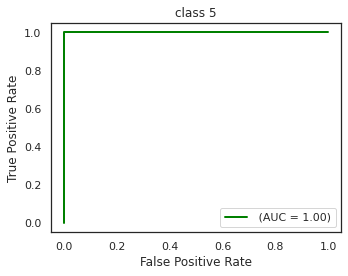

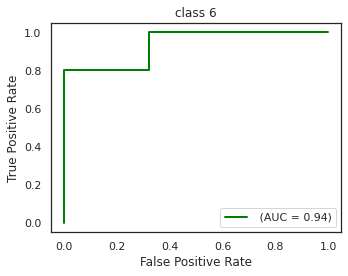

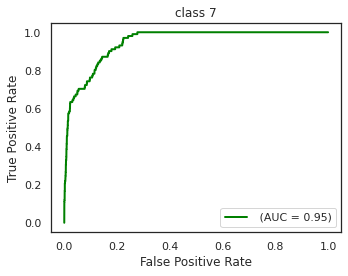

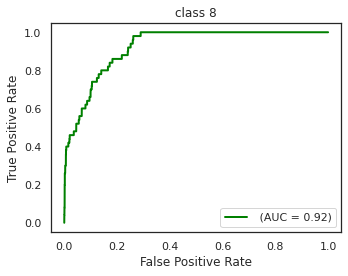

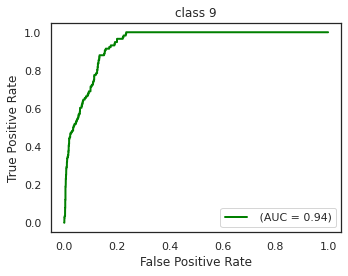

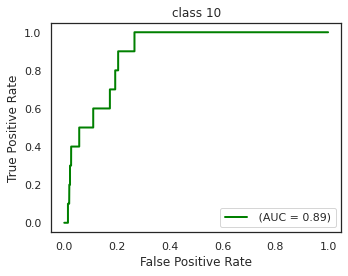

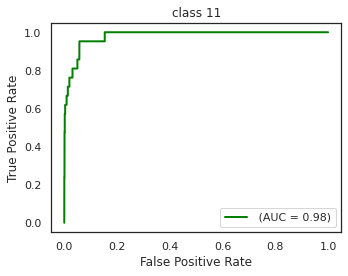

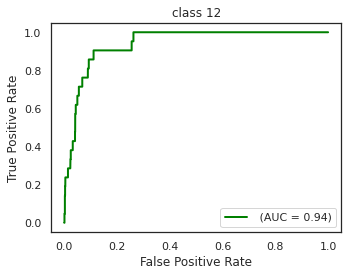

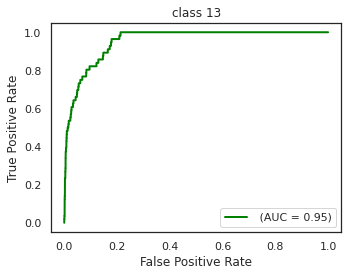

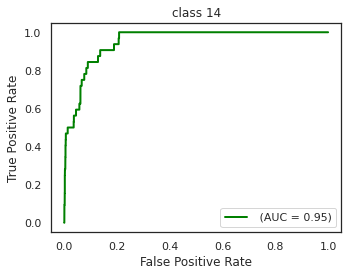

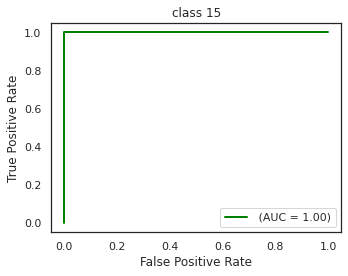

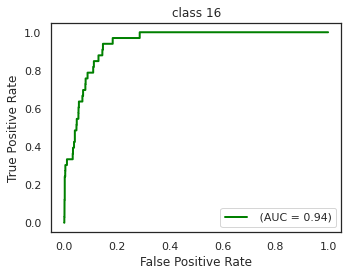

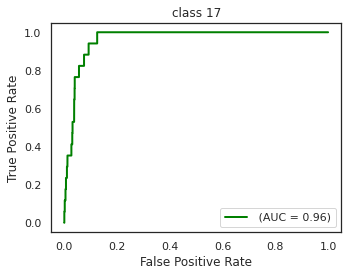

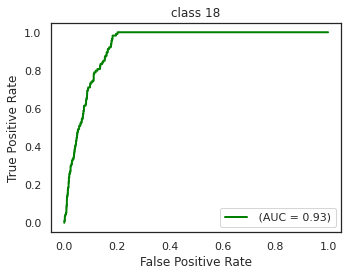

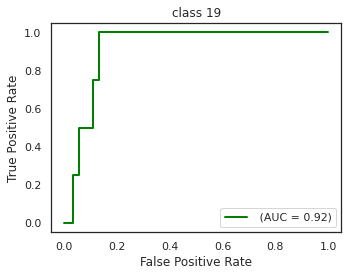

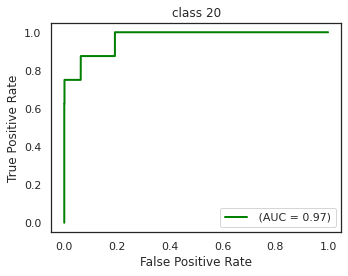

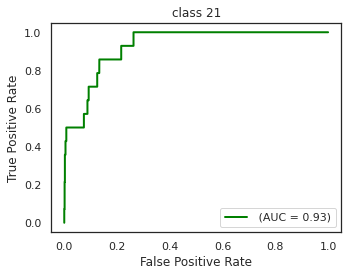

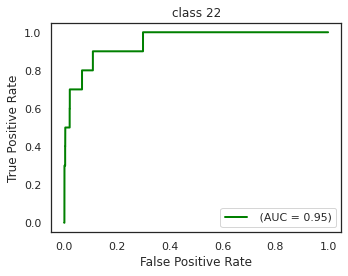

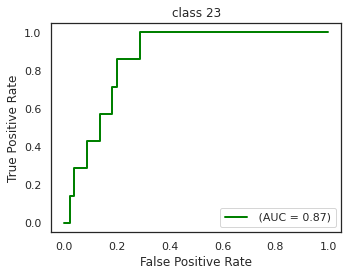

In [185]:
plot_ROC(y_train)

### *Confusion Matrix*

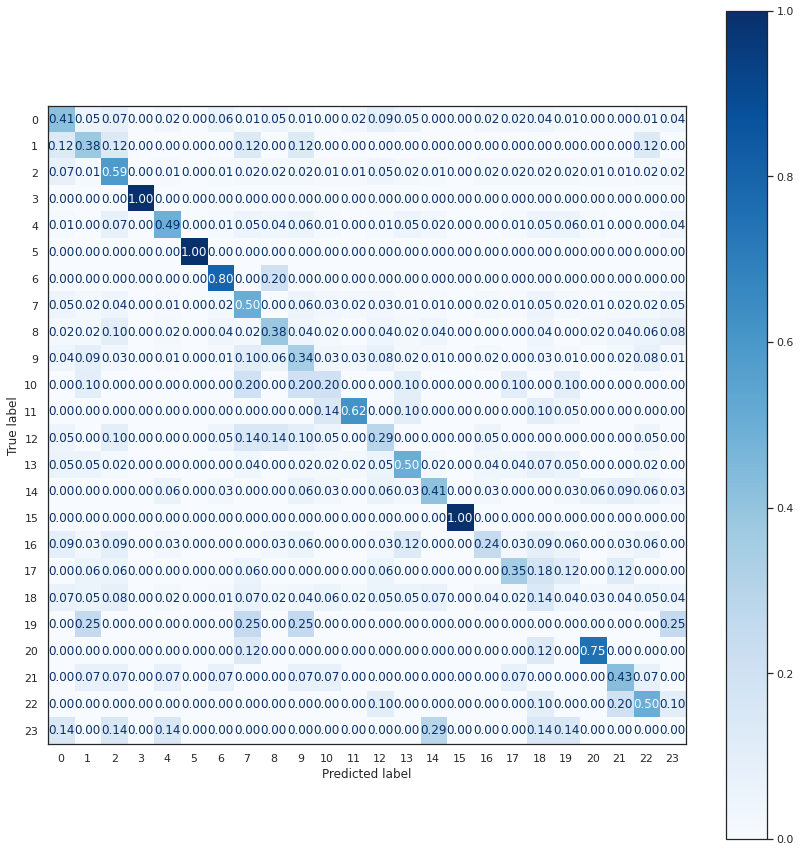

In [192]:
from sklearn.metrics import plot_confusion_matrix

# Create a figure and axes
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

# Plot the confusion matrix
plot_confusion_matrix(lr,
                      X_valid,
                      y_valid,
                      normalize='true',
                      display_labels=np.unique(y_valid),
                      values_format='.2f',
                      cmap=plt.cm.Blues,
                      ax=ax)

# Save and show the figure
plt.tight_layout()
plt.savefig('./figure/confusion_matrix.pdf')
plt.show()


The model has different results: on the one hand, it is good at predicting some classes (as is the case of class 6); it also is perfect at predicting some classes (for example, 3,5 and 15), suggesting that it may be overfitting the training data. On the other hand, the model performs badly when classifying other classes (as is the case of classes 10, 16 or 19). Let's see if we can improve this by exploring other algorithms.

### *Brief note about feature importance*

In [244]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the random forest classifier on the training data
rfc.fit(X_train, y_train)

# Get the prediction on the validation data
y_valid_pred = rfc.predict(X_valid)

# Get the dataframe of feature and importance
df_fi_rfc = pd.DataFrame(np.hstack((features.reshape(-1, 1), rfc.feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

feature_importance = df_fi_rfc.sort_values(ascending=False, by='Importance').reset_index(drop=True)
feature_importance[:15]

,Features,Importance
0,Months to return_more than 24 months,0.0318501
1,Age At Release _25-34,0.0303537
2,Months to return_18-24 months,0.0279099
3,Months to return_6-12 months,0.0276597
4,Race - Ethnicity_White - Non-Hispanic,0.0265957
5,Age At Release _35-44,0.0259151
6,Race - Ethnicity_Black - Non-Hispanic,0.0258388
7,Months to return_12-18 months,0.0255742
8,Age At Release _Under 25,0.0252644
9,Offense_Other-Other Violent,0.0248549


Months seem to be an important feature for classifying new offense types. Also, age seems to be important, specially from 25 to 34 years. Non-hispanic white and Non-hispanic black remain in the 10 most important features. Finally, it is interesting that the supervising district appears in the top 10. This suggests that geography plays a role affecting the type of new offense.

## Exploring Logistic Regression, Decision Trees and Random Forest with hyperparameter tuning

Apart from logisitc regression, we can explore the performance of other models, such as:

- Decision Trees: are the fundamental components of Random Forests; they can also estimate the probability that an instance belongs to a particular class k. However, they are very sensitive to small variations in the training data.
- Random Forest: This is the ensemble version of Decicion Trees. Sensitiviness in the training data is averaged out.

### *Load the models*

In [226]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

models = {'lr': LogisticRegression(class_weight='balanced', random_state=42),
          'dtc': DecisionTreeClassifier(class_weight='balanced', random_state=42),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=42)}
          #'xgbc': XGBClassifier(seed=42)}

### *Initialize pipeline*

In [227]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

### *Predefined split cross-validator*

In [228]:
from sklearn.model_selection import PredefinedSplit

# Combine the feature matrix in the training and validation data
X_train_valid = np.vstack((X_train, X_valid))

# Combine the target vector in the training and validation data
y_train_valid = np.append(y_train, y_valid)

# Get the indices of training and validation data
train_valid_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_valid.shape[0], 0))

# The PredefinedSplit
ps = PredefinedSplit(train_valid_idxs)

### *Hyperparameter tuning*

In [229]:
param_grids = {}

In [230]:
# Parameter grids for logistic regression

# The grids for C
C_grids = [10 ** i for i in range(-2, 3)]

# The grids for tol
tol_grids = [10 ** i for i in range(-6, -1)]

# Update param_grids
param_grids['lr'] = [{'model__C': C_grids,
                      'model__tol': tol_grids}]

In [231]:
# Parameter grids for Decision Tree

# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['dtc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

In [232]:
# Parameter grids for Random Forest 

# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

In [235]:
# Parameter grids for XG boost

# The grids for eta
#eta_grids = [10 ** i for i in range(-2, 1)]

# The grids for gamma
#gamma_grids = [0, 10, 100]

# The grids for lambda
#lambda_grids = [10 ** i for i in range(-2, 2)]

# Update param_grids
#param_grids['xgbc'] = [{'model__eta': eta_grids,
#                        'model__gamma': gamma_grids,
#                        'model__lambda': lambda_grids}]

### *Run the models*

In this case, we will use **F1 score**, which can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

    F1 = 2 * (precision * recall) / (precision + recall)

In [236]:
import os

# Make directory
directory = os.path.dirname('./cv_results/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [237]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_param_estimator_gs = []

for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_micro',
                      n_jobs=2,
                      cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_valid, y_train_valid)
    
    # Update best_score_param_estimator_gs
    best_score_param_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf='./cv_results/' + acronym + '.csv', index=False)

### *Results*

In [238]:
# Sort best_score_param_estimator_gs in descending order of the best_score_
best_score_param_estimator_gs = sorted(best_score_param_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_param_estimator_gs
pd.DataFrame(best_score_param_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.846889,"{'model__C': 10, 'model__tol': 1e-06}","(LogisticRegression(C=10, class_weight='balanc..."
1,0.843790,"{'model__min_samples_leaf': 1, 'model__min_sam...","((DecisionTreeClassifier(ccp_alpha=0.0, class_..."
2,0.821069,"{'model__min_samples_leaf': 1, 'model__min_sam...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."


Based on the grid search, Logistic Regression remains as the best model for predicting the class of new offenses, with the highest F1 score. 